# Real estate price prediction
## 1. 데이터 가져오기

In [29]:
import sys
assert sys.version_info >= (3,5)

# 사이킷런 >=0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [30]:
# 그래프에서 마이너스 폰트 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus'] = False

# 한글폰트 사용
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = 'GULIM'
plt.rcParams['xtick.labelsize'] = 12.
plt.rcParams['ytick.labelsize'] = 12.

In [31]:
# 시각화
# 그림을 저장할 위치 
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ml_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "."+fig_extension)
    print("그림 저장: ",fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# 불필요한 경고 무시
import warnings
warnings.filterwarnings(action = "ignore", message="^internal gelsd")

In [32]:
import pandas as pd

PROJECT_ROOT_DIR = "."
FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")

def load_data(file_path=FILE_PATH):   
    csv_path = os.path.join(file_path, "real_estate.csv")
    return pd.read_csv(csv_path, encoding='cp949', low_memory=False)  # 한글깨짐 방지

raw_df = load_data()
raw_df.head(3)

,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명
0,11290-2020-4-0000066-1,1.12901E+18,11290,성북구,1129013800,장위동,2020,4,신고,1,0.0,59.92,2,5.0,2001,아파트,749000000,0.0,래미안 장위포레카운티
1,11290-2020-4-0000628-1,1.12901E+18,11290,성북구,1129013400,길음동,2020,4,신고,1,0.0,84.77,2,18.0,2001,아파트,1200000000,0.0,롯데캐슬 클라시아
2,11530-2020-4-0014284-1,1.15301E+18,11530,구로구,1153010200,구로동,2020,4,신고,1,NaN,36.90,0,1.0,2001,아파트,105000000,1994.0,궁전아트빌라


## 2. 데이터 구조 훑어보기

In [33]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176001 entries, 0 to 176000
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   실거래가아이디  176001 non-null  object 
 1   지번코드     176001 non-null  object 
 2   시군구코드    176001 non-null  int64  
 3   자치구명     176001 non-null  object 
 4   법정동코드    176001 non-null  int64  
 5   법정동명     176001 non-null  object 
 6   신고년도     176001 non-null  int64  
 7   업무구분코드   176001 non-null  int64  
 8   업무구분     176001 non-null  object 
 9   물건번호     176001 non-null  int64  
 10  대지권면적    89147 non-null   float64
 11  건물면적     176001 non-null  float64
 12  관리구분코드   176001 non-null  object 
 13  층정보      163838 non-null  float64
 14  건물주용도코드  176001 non-null  int64  
 15  건물주용도    176001 non-null  object 
 16  물건금액     176001 non-null  int64  
 17  건축년도     175436 non-null  float64
 18  건물명      163838 non-null  object 
dtypes: float64(4), int64(7), object(8)
memory usage: 25.5+ MB


In [36]:
# 모든 숫자형 특성의 요약 정보
raw_df[['신고년도','대지권면적','건물면적','층정보','물건금액','건축년도']].describe()

,신고년도,대지권면적,건물면적,층정보,물건금액,건축년도
count,176001.0,89147.000000,176001.000000,163838.000000,1.760010e+05,175436.000000
mean,2020.0,48.176158,71.489719,6.725540,6.283288e+08,1988.342336
std,0.0,58.385424,66.030144,5.754692,6.245526e+08,162.107028
min,2020.0,0.000000,5.070000,-3.000000,1.700000e+07,0.000000
25%,2020.0,23.020000,41.260000,3.000000,2.500000e+08,1993.000000
50%,2020.0,30.570000,59.760000,5.000000,4.480000e+08,2002.000000
75%,2020.0,45.500000,84.820000,10.000000,8.000000e+08,2011.000000
max,2020.0,6086.000000,2804.970000,67.000000,2.900000e+10,2021.000000


그림 저장:  attribute_histogram_plots


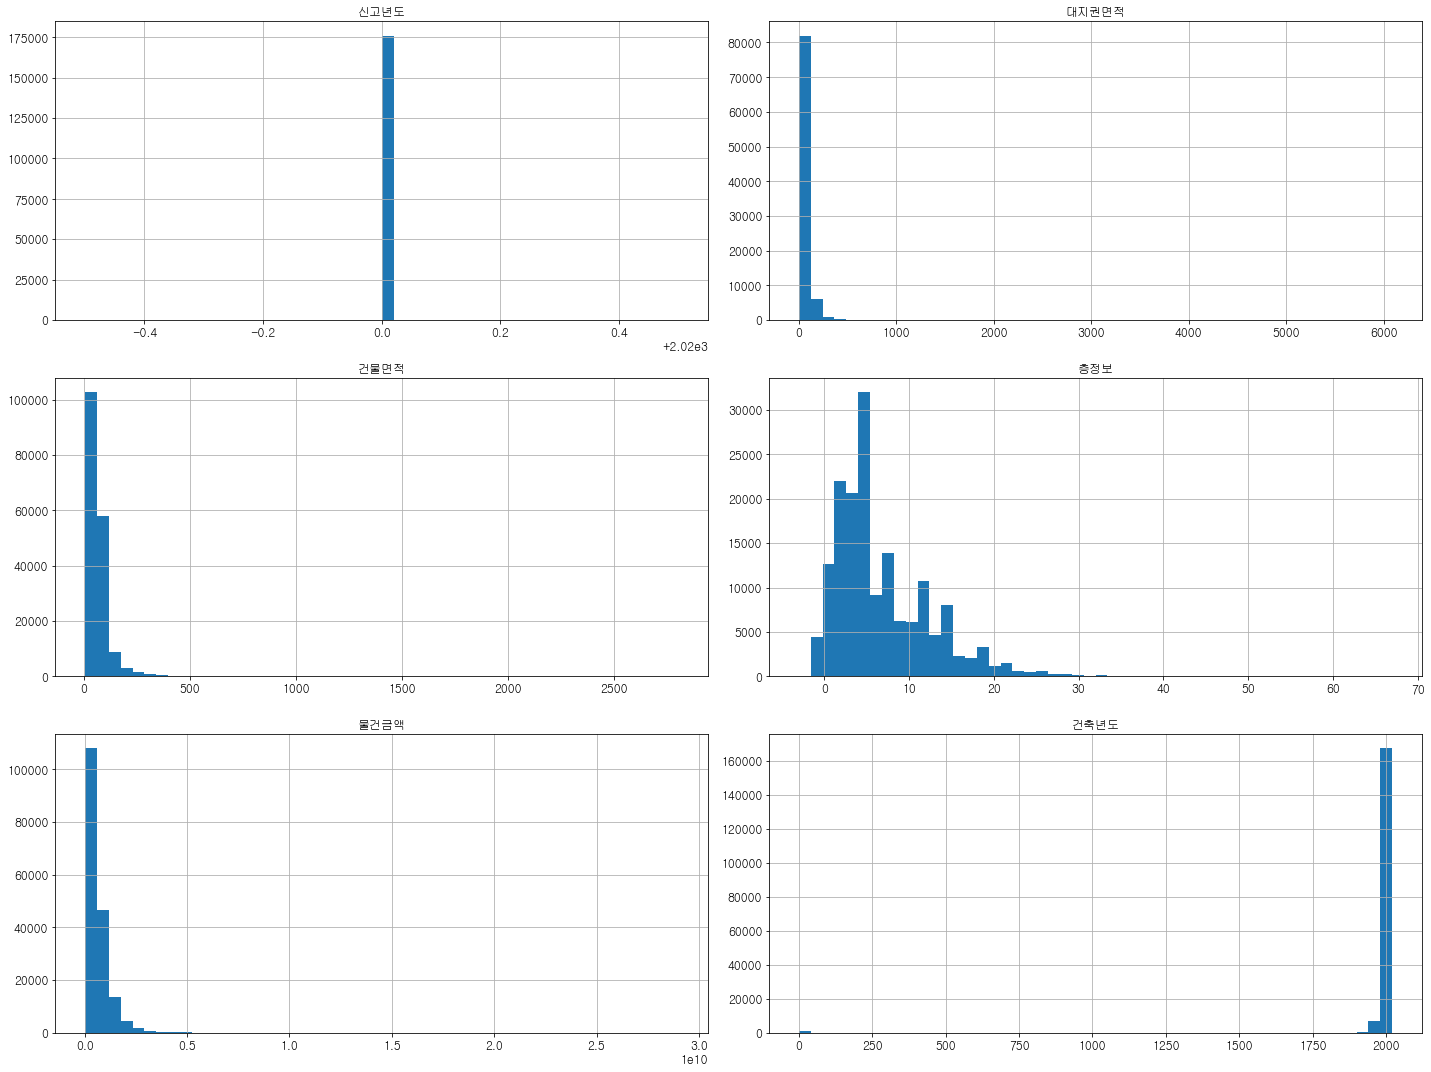

In [37]:
# 모든 숫자형 특성의 히스토그램
%matplotlib inline
import matplotlib.pyplot as plt
raw_df[['신고년도','대지권면적','건물면적','층정보','물건금액','건축년도']].hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## 3. 필요한 데이터만 추출

In [40]:
df = raw_df[['자치구명','대지권면적','건물면적','층정보','건물주용도','건축년도','물건금액']]
print(df.shape)
df.head()

(176001, 7)


,자치구명,대지권면적,건물면적,층정보,건물주용도,건축년도,물건금액
0,성북구,0.0,59.92,5.0,아파트,0.0,749000000
1,성북구,0.0,84.77,18.0,아파트,0.0,1200000000
2,구로구,NaN,36.90,1.0,아파트,1994.0,105000000
3,용산구,NaN,59.55,2.0,아파트,2001.0,830000000
4,용산구,NaN,64.43,5.0,아파트,1971.0,735000000


In [42]:
# 건축년도 Null과 0 값을 drop & 건물면적 Null값 drop

df = df.dropna(subset=["건축년도","건물면적"], axis=0)
df = df[df['건축년도']!=0]
print(df.shape)
df.head()

(174284, 7)


,자치구명,대지권면적,건물면적,층정보,건물주용도,건축년도,물건금액
2,구로구,NaN,36.90,1.0,아파트,1994.0,105000000
3,용산구,NaN,59.55,2.0,아파트,2001.0,830000000
4,용산구,NaN,64.43,5.0,아파트,1971.0,735000000
5,용산구,NaN,105.75,9.0,아파트,1982.0,1430000000
6,용산구,43.9,73.04,3.0,연립주택,1993.0,400000000


In [49]:
# index reset
df = df.reset_index()

In [50]:
df.isnull().sum()

index        0
자치구명         0
대지권면적    86854
건물면적         0
층정보      12157
건물주용도        0
건축년도         0
물건금액         0
dtype: int64

## 4. 훈련 & 테스트셋 분리
- 계층적 추출 방법 사용
- corr 확인 결과 건물면적이 중요한 feature라고 판단
- 건물면적 카테고리를 기반으로 샘플링

<AxesSubplot:>

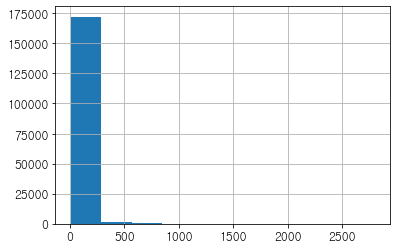

In [51]:
df["건물면적"].hist()

<AxesSubplot:>

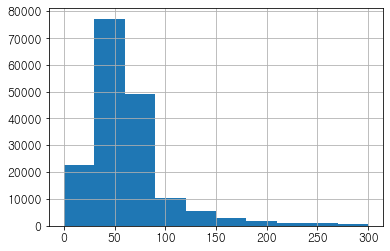

In [52]:
df["건물면적"].hist(range=(0.0,300), bins=10)

<AxesSubplot:>

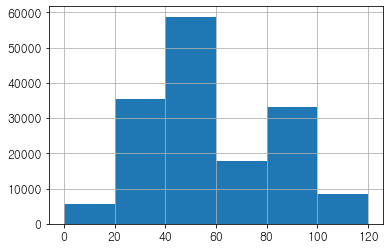

In [55]:
df["건물면적"].hist(bins = [0.0, 20, 40, 60, 80, 100, 120, np.inf])

In [66]:
# 계층적 추출 방법
from sklearn.model_selection import StratifiedShuffleSplit  

def split_train_test_by_str(data, test_ratio, num_splits=10):
    split = StratifiedShuffleSplit(n_splits=num_splits, test_size=test_ratio, random_state=42)     

    target_str = pd.cut(data["건물면적"],
                        bins = [0.0, 20, 40,60, 80, 100, 120, np.inf],  
                        labels = [1,2,3,4,5,6,7])

    for str_train_index, str_test_index in split.split(data, target_str):  
        str_train_set = data.loc[str_train_index]
        str_test_set = data.loc[str_test_index]  
    return str_train_set, str_test_set

# train_set, test 생성
train_set, test_set = split_train_test_by_str(df, 0.2, 1)
train_set.head(3)

,index,자치구명,대지권면적,건물면적,층정보,건물주용도,건축년도,물건금액
32369,32643,서초구,NaN,19.99,6.0,아파트,2013.0,250000000
120080,121153,서대문구,NaN,114.83,8.0,아파트,2009.0,750000000
7570,7627,영등포구,NaN,49.64,14.0,아파트,1986.0,630000000


In [68]:
housing_train = train_set.copy()
housing_test = test_set.copy()

In [69]:
housing_train = housing_train.drop("index", axis=1)
housing_test = housing_test.drop("index", axis=1)
housing_train.head(3)

,자치구명,대지권면적,건물면적,층정보,건물주용도,건축년도,물건금액
32369,서초구,NaN,19.99,6.0,아파트,2013.0,250000000
120080,서대문구,NaN,114.83,8.0,아파트,2009.0,750000000
7570,영등포구,NaN,49.64,14.0,아파트,1986.0,630000000


## 5. 데이터 이해하기


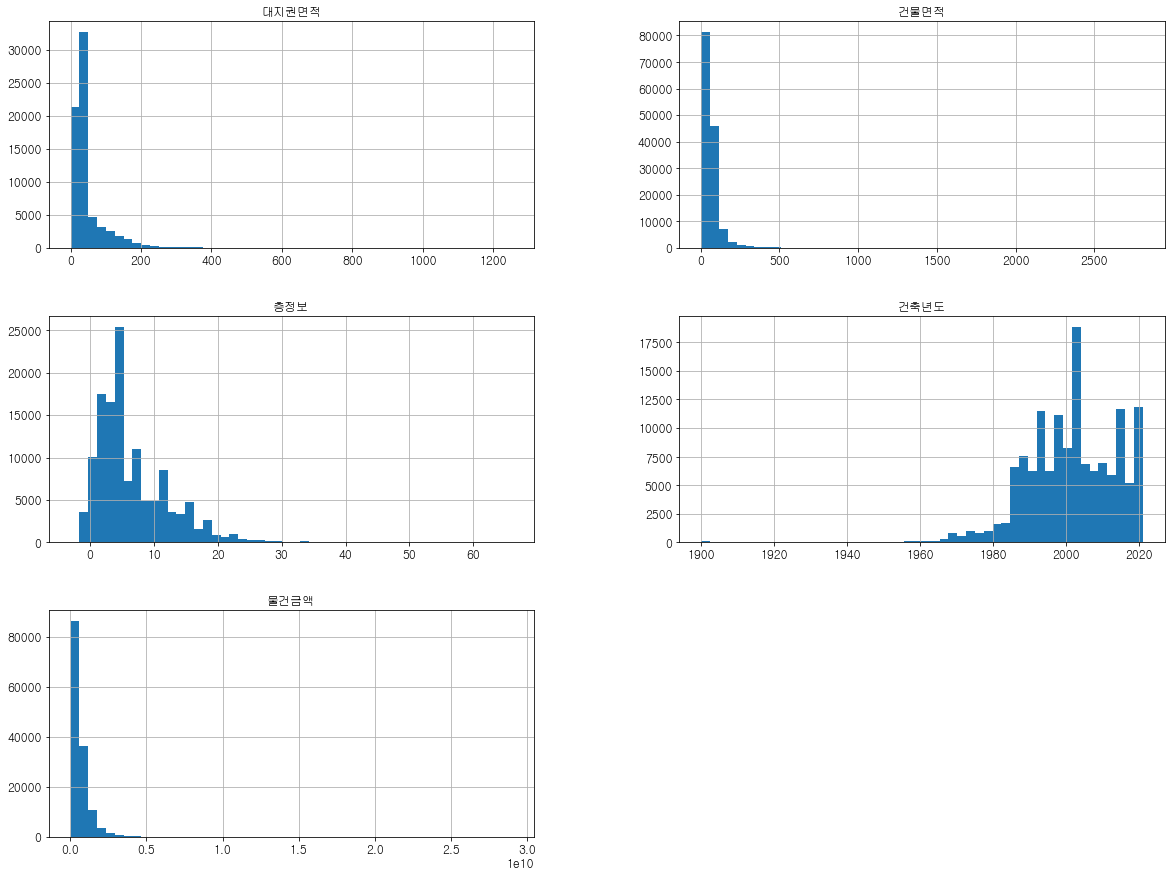

In [70]:
# 변수들로 histogram 그려보기
%matplotlib inline
import matplotlib.pyplot as plt
housing_train.hist(bins=50, figsize=(20,15))
plt.show()

그림 저장:  scatter_matrix_plot


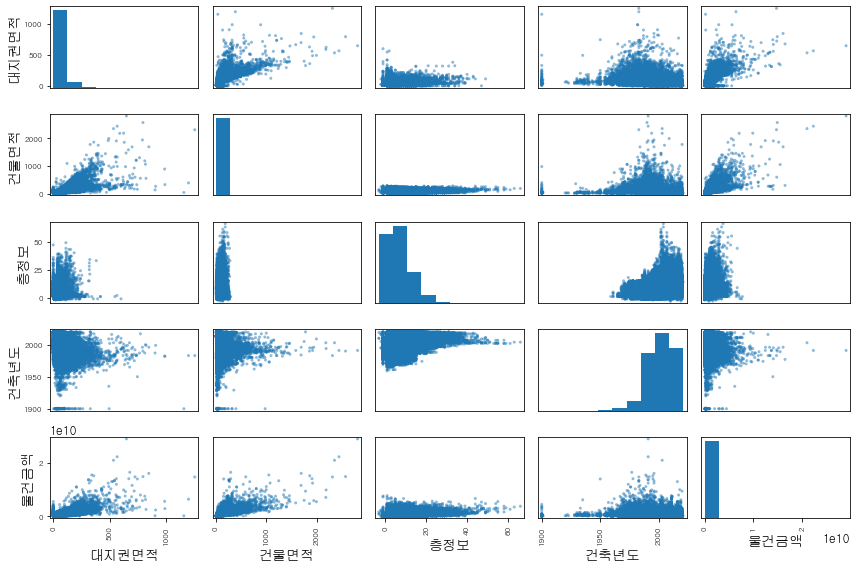

In [72]:
# scatter plot
from pandas.plotting import scatter_matrix

scatter_matrix(housing_train, figsize=(12,8))
save_fig("scatter_matrix_plot")

## 6. 학습을 위한 데이터 준비
- 데이터 파이프라인 준비
- 연속형 파이프라인
    - 파이프라인에 추가할 전처리 아이디어:
        - standard scaler
        - 연식 변수 추가
- 범주형 파이프라인
    - 자치구명, 건물주용도
    

In [73]:
housing_train_X = housing_train.drop("물건금액", axis=1)
housing_train_y = housing_train["물건금액"].copy()

###  1) 연속형 파이프라인


In [79]:
# 선택한 컬럼만 가져오기
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [82]:
# 대지권면적, 층정보의 null 채워주기
from numpy import nan as NA 

land_area_ix, floor_ix = 0, 2  # 대지권면적, 층정보

class FillNullValue(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        for i in range(len(X)):
            if np.isnan(X[i,land_area_ix])==True:  # 대지권면적 0으로
                X[i,land_area_ix] = 0
            if np.isnan(X[i, floor_ix])==True:  # 층정보 1로
                 X[i, floor_ix] = 1
        return X

In [83]:
# 특성을 자동으로 추가해 주는 클래스 만들기 - 연식
# 건축년도 삭제후 건축년도 자리에 붙임

from sklearn.base import BaseEstimator, TransformerMixin

yr_built_ix = 3  # 건축년도 column

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, h_age = True): 
        self.h_age = h_age
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        h_age = np.zeros(len(X))
       
        for i in range(len(X)):
            h_age[i] = datetime.today().year - X[i, yr_built_ix]
        
        return np.concatenate((np.delete(X, 3, axis=1), h_age.astype(int)[:,None]), axis=1)  # 3번째 인덱스 값 삭제 -> 건축년도

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime

num_attribs = list(housing_train_X.drop(["자치구명","건물주용도"], axis=1)) # categorical 변수 제외

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('fill_na', FillNullValue()),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])

housing_num_tr = num_pipeline.fit_transform(housing_train_X)

In [89]:
print(housing_num_tr.shape)
housing_num_tr

(139427, 4)


array([[-0.53713073, -0.77703685, -0.04836741, -0.94842847],
       [-0.53713073,  0.65017282,  0.302795  , -0.61914234],
       [-0.53713073, -0.33084572,  1.35628222,  1.27425292],
       ...,
       [ 0.33246967, -0.05666014, -0.75069222, -0.0428916 ],
       [ 0.20395838, -0.42339464, -0.92627343,  0.86264526],
       [-0.53713073, -0.18457328, -0.57511102, -0.61914234]])

### 2) 전체 파이프라인
- 범주형 파이프라인 추가 (OneHotEncoder)

In [90]:
from sklearn.compose import ColumnTransformer  # 원래 만들어진 pipeline에 추가하기 위한 모듈
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_train_X)
cat_attribs = ['건물주용도','자치구명']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(categories='auto', sparse=False), cat_attribs),  # OneHotEncoder  # drop='first'
])

housing_prepared = full_pipeline.fit_transform(housing_train_X)
print(housing_prepared.shape)
housing_prepared

(139427, 33)


array([[-0.53713073, -0.77703685, -0.04836741, ...,  0.        ,
         0.        ,  0.        ],
       [-0.53713073,  0.65017282,  0.302795  , ...,  0.        ,
         0.        ,  0.        ],
       [-0.53713073, -0.33084572,  1.35628222, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.33246967, -0.05666014, -0.75069222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20395838, -0.42339464, -0.92627343, ...,  0.        ,
         0.        ,  0.        ],
       [-0.53713073, -0.18457328, -0.57511102, ...,  0.        ,
         0.        ,  0.        ]])

In [91]:
housing_prepared[30]  # 단독주택 0 아파트 1 연립주택 2 오피스텔 3

array([-0.53713073,  0.06794231,  0.6539574 ,  0.12175146,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ])

In [92]:
print( housing_train_X['건물주용도'].values)   # 4개
print( housing_train_X['자치구명'].value_counts().index )  # 25개

['아파트' '아파트' '아파트' ... '연립주택' '연립주택' '아파트']
Index(['강서구', '은평구', '노원구', '송파구', '구로구', '양천구', '강동구', '성북구', '도봉구', '강북구',
       '영등포구', '마포구', '강남구', '중랑구', '서초구', '관악구', '동작구', '동대문구', '서대문구', '금천구',
       '광진구', '성동구', '용산구', '종로구', '중구'],
      dtype='object')


In [31]:
housing_train_X_df = pd.DataFrame(
    housing_prepared, 
    columns = ['대지권면적', '건물면적', '층정보','건축년도', 
               '단독주택','아파트','연립주택','오피스텔',
               '강남구','강동구','강북구','강서구','관악구','광진구','구로구','금천구','노원구','도봉구',
               '동대문구','동작구','마포구','서대문구','서초구','성동구','성북구','송파구','양천구','영등포구',
               '용산구','은평구','종로구','중구','중랑구']
    )
housing_train_X_df.head()

,대지권면적,건물면적,층정보,건축년도,단독주택,아파트,연립주택,오피스텔,강남구,강동구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,-0.028875,-0.493693,-0.750397,-1.113700,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.533760,0.198981,-0.750397,-0.125286,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.140247,-0.631500,-0.223335,-1.360804,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.073762,-0.785984,-0.047648,-1.031332,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.199863,-0.631349,-0.574710,-0.866597,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------

## 7. 모델 선택과 학습
 - train 데이터 학습, 같은 데이터로 평가

In [ ]:
# 변수명 변경
housing_labels = housing_train_y
strat_test_set = housing_test
#strat_test_set = strat_test_set.drop("index", axis=1)

### 1) LinearRegression

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 학습될 모델 생성
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) 

# 학습
housing_predictions = lin_reg.predict(housing_prepared)

# 평가
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

362956411.48307073

### 2) DecisionTreeRegressor

In [99]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)   # 모델에 사용된 train 데이터로 평가
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

31605326.764265783

### +) 교차검증을 사용한 평가

In [100]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv=10)  

tree_rmse_scores = np.sqrt(-scores) # scores: 평균 점수 계산한 값

In [101]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())
    
display_scores(tree_rmse_scores)

점수: [2.94835368e+08 3.02155273e+08 2.98934373e+08 3.15900139e+08
 2.77580550e+08 2.56008903e+08 2.85899501e+08 2.67088870e+08
 2.86523410e+08 2.67402001e+08]
평균: 285232838.8363912
표준편차: 17517536.965082683


In [102]:
# 선형 모델
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [3.66203898e+08 3.64891580e+08 3.62601813e+08 3.63549314e+08
 3.61314815e+08 3.65890882e+08 3.82902258e+08 3.72915823e+08
 3.56953645e+08 3.35420523e+08]
평균: 363264455.05827296
표준편차: 11473492.834490571


### 3) 앙상블 학습 모델 - RandomForestRegressor

In [103]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42) # n_est: tree 연결 개수
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [104]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

85023029.45663531

In [105]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [2.30473605e+08 2.40996912e+08 2.29323740e+08 2.09092985e+08
 2.24949408e+08 1.93957970e+08 2.40108269e+08 2.13695417e+08
 2.07364506e+08 1.94572172e+08]
평균: 218453498.3122534
표준편차: 16387646.34800692


## 8. 모델 세부 튜닝

### 1) 그리드 탐색

In [123]:
from sklearn.model_selection import GridSearchCV 

param_grid = [ 
    {'n_estimators': [3,10,30], 'max_features': [2, 4, 6, 8]}, 
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}  
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)  
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [107]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

pd.DataFrame(grid_search.cv_results_).head()

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.943119,0.037974,0.057730,0.011153,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-6.528459e+16,-7.086767e+16,...,-6.538523e+16,6.730053e+15,14,-1.854551e+16,-1.683959e+16,-1.631010e+16,-1.734322e+16,-1.789539e+16,-1.738676e+16,7.825467e+14
1,2.907542,0.047452,0.174505,0.006605,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-5.213653e+16,-5.990350e+16,...,-5.219147e+16,6.143201e+15,5,-1.102408e+16,-1.021632e+16,-1.043567e+16,-1.021904e+16,-1.040751e+16,-1.046052e+16,2.963010e+14
2,8.952047,0.143270,0.532319,0.013875,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-4.848186e+16,-5.530795e+16,...,-4.954657e+16,5.265843e+15,4,-8.591774e+15,-8.516922e+15,-8.268187e+15,-8.267177e+15,-8.499676e+15,-8.428747e+15,1.351058e+14
3,1.109867,0.042820,0.067778,0.006487,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-6.363198e+16,-7.102406e+16,...,-6.405343e+16,5.649760e+15,12,-1.661006e+16,-1.646202e+16,-1.548032e+16,-1.650807e+16,-1.754587e+16,-1.652127e+16,6.549740e+14
4,3.394406,0.065313,0.181305,0.010885,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-5.312628e+16,-6.161293e+16,...,-5.358717e+16,6.602807e+15,9,-1.006780e+16,-9.977578e+15,-1.028371e+16,-9.984688e+15,-1.058928e+16,-1.018061e+16,2.323666e+14


In [124]:
# 그리드 탐색 결과
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

255705355.32426572 {'max_features': 2, 'n_estimators': 3}
228454534.98843613 {'max_features': 2, 'n_estimators': 10}
222590598.89478055 {'max_features': 2, 'n_estimators': 30}
253087784.65063518 {'max_features': 4, 'n_estimators': 3}
231489018.6055483 {'max_features': 4, 'n_estimators': 10}
222175573.3693818 {'max_features': 4, 'n_estimators': 30}
256610018.6297325 {'max_features': 6, 'n_estimators': 3}
228516660.3611415 {'max_features': 6, 'n_estimators': 10}
220350179.9510211 {'max_features': 6, 'n_estimators': 30}
257700077.10883674 {'max_features': 8, 'n_estimators': 3}
230074451.3158684 {'max_features': 8, 'n_estimators': 10}
221330813.65594158 {'max_features': 8, 'n_estimators': 30}
260079963.6709701 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
232292281.5060541 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
258214196.80846348 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
232490161.23907816 {'bootstrap': False, 'max_features': 3, 'n_estimat

### 2) 랜덤 탐색

In [109]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, 
                                scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002858132BAC8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000285813303C8>},
                   random_state=42, scoring='neg_mean_squared_error')

In [110]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

218544853.81871048 {'max_features': 7, 'n_estimators': 180}
227213238.461385 {'max_features': 5, 'n_estimators': 15}
221796281.07463717 {'max_features': 3, 'n_estimators': 72}
223692804.6866439 {'max_features': 5, 'n_estimators': 21}
218997028.2220248 {'max_features': 7, 'n_estimators': 122}
221852516.81091967 {'max_features': 3, 'n_estimators': 75}
221649881.55745128 {'max_features': 3, 'n_estimators': 88}
220310980.64816234 {'max_features': 5, 'n_estimators': 100}
220409540.52436066 {'max_features': 3, 'n_estimators': 150}
283227596.14590186 {'max_features': 5, 'n_estimators': 2}


## 9. 최종 모델 평가
- 특성 중요도와 결과

In [111]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.18562794, 0.34470343, 0.03355956, 0.10301481, 0.01541183,
       0.03941592, 0.0574007 , 0.01097694, 0.06972992, 0.00184516,
       0.00252231, 0.00173693, 0.00133591, 0.00280235, 0.0032887 ,
       0.00181079, 0.00476691, 0.00547647, 0.00115171, 0.00363777,
       0.00767981, 0.00160083, 0.04316327, 0.00966197, 0.00274457,
       0.01557284, 0.00315967, 0.00236609, 0.01529071, 0.00255144,
       0.00222062, 0.00147113, 0.00230098])

In [118]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("물건금액", axis=1)
y_test = strat_test_set["물건금액"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

214630054.33044952